In [63]:
import random
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid


In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [65]:
# Load datasets from disk with transforms applied
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for CNNs
    transforms.ToTensor()])

train_data = datasets.INaturalist(root='data/train_mini', version="2021_train_mini", transform=transform, download=False)

train_data_sample_indices = random.sample(range(len(train_data)), 10000)


imgs = torch.stack([train_data[i][0] for i in train_data_sample_indices], dim=3)
sample_mean = imgs.view(3, -1).mean(dim=1)
sample_std = imgs.view(3, -1).std(dim=1)

In [ ]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),    
    transforms.ToTensor(),
    transforms.Normalize(mean=sample_mean, std=sample_std)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=sample_mean, std=sample_std)
])



# Load datasets from disk with transforms applied
train_data = datasets.INaturalist(root='data/train_mini', version="2021_train_mini", transform=train_transform, download=False)
validation_data = datasets.INaturalist(root='data/validation', version="2021_valid", transform=val_transform, download=False)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(validation_data, batch_size=128, shuffle=True, num_workers=4)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(validation_data)}")

Training samples: 500000
Validation samples: 100000


In [67]:
cat_list = [int(cat[1:5]) for cat in train_data.all_categories if "Animalia_Chordata_Aves" in cat]
# get corresponding labels

In [68]:
# bird_indices = []
# for i, (_, label) in enumerate(train_data):
#     print(i, label)
#     if label > 4596:
#         break
#     if label >= 3111 and label <= 4596:
#         bird_indices.append(i)

In [69]:
# with open('bird_indices.txt', 'w') as f:
#     for line in bird_indices:
#         f.write(f"{line}\n")

In [70]:
bird_indices = []
with open('bird_indices.txt', 'r') as f:
    for line in f:
        bird_indices.append(int(line[0:-1]))

In [71]:
# bird_val_indices = []
# for i, (_, label) in enumerate(validation_data):
#     if label > 4596:
#         break
#     if label >= 3111 and label <= 4596:
#         bird_val_indices.append(i)

In [72]:
# with open('bird_val_indices.txt', 'w') as f:
#     for line in bird_val_indices:
#         f.write(f"{line}\n")

In [73]:
bird_val_indices = []
with open('bird_val_indices.txt', 'r') as f:
    for line in f:
        bird_val_indices.append(int(line[0:-1]))

In [74]:
from torch.utils.data import Subset

# Find all indices where the target (label) corresponds to birds
# Create a subset dataset containing only birds
train_data_birds = Subset(train_data, bird_indices)

# Create a DataLoader for the filtered dataset
train_loader_birds = DataLoader(train_data_birds, batch_size=128, shuffle=True, num_workers=4)

val_data_birds = Subset(validation_data, bird_val_indices)
val_loader_birds = DataLoader(val_data_birds, batch_size=128, shuffle=True, num_workers=4)

print(f"Filtered train dataset contains {len(train_data_birds)} bird images.")
print(f"Filtered val dataset contains {len(val_data_birds)} bird images.")

Filtered train dataset contains 74300 bird images.
Filtered val dataset contains 14860 bird images.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


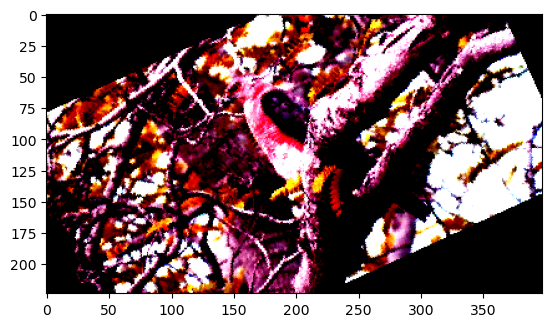

In [75]:
plt.imshow(train_data_birds[1][0].permute(1,2,0))

In [76]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader_birds)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\lib\site-packages\torch\utils\data\_utils\worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "c:\ProgramData\Anaconda3\lib\site-packages\torch\utils\data\_utils\fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "c:\ProgramData\Anaconda3\lib\site-packages\torch\utils\data\_utils\collate.py", line 317, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "c:\ProgramData\Anaconda3\lib\site-packages\torch\utils\data\_utils\collate.py", line 174, in collate
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "c:\ProgramData\Anaconda3\lib\site-packages\torch\utils\data\_utils\collate.py", line 174, in <listcomp>
    return [collate(samples, collate_fn_map=collate_fn_map) for samples in transposed]  # Backwards compatibility.
  File "c:\ProgramData\Anaconda3\lib\site-packages\torch\utils\data\_utils\collate.py", line 142, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "c:\ProgramData\Anaconda3\lib\site-packages\torch\utils\data\_utils\collate.py", line 214, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [3, 298, 224] at entry 0 and [3, 224, 336] at entry 1


In [ ]:
n_classes = len(cat_list)
n_classes

1486

In [ ]:
# Define a Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 56 * 56, 128)  # 32 channels, 56x56 image size after pooling
        self.fc2 = nn.Linear(128, num_classes)   # Output layer
        
        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> MaxPool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> MaxPool
        x = x.view(x.shape[0], -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Output layer
        return x

In [ ]:
def remap_labels(labels):
    return (labels - 3111).long()  # Convert labels to tensor and ensure they are Long type


def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()  # Set to training mode

    train_n = len(train_loader)
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            labels = remap_labels(labels).to(device)
            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        # Print epoch stats
        print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f} - Accuracy: {100 * correct / total:.2f}%")


In [ ]:
#simple_cnn = SimpleCNN(num_classes=n_classes).to(device)
#criterion = nn.CrossEntropyLoss().to(device)
#optimizer = optim.Adam(simple_cnn.parameters(), lr=0.001)

# Train the model
#train_model_eval(simple_cnn, train_loader_birds, criterion, optimizer, epochs=100)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Define a Simple CNN Model
class SimpleCNN_2(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN_2, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 56 * 56, 512)  # 16 channels, 56x56 image size after pooling
        self.fc2 = nn.Linear(512, num_classes)   # Output layer
        
        # Dropout to prevent overfitting
        self.conv_dropout = nn.Dropout2d(0.3)
        self.conv2_dropout = nn.Dropout2d(0.3)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> MaxPool
        x = self.conv_dropout(x)
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> MaxPool
        x = self.conv2_dropout(x)
        x = x.view(x.shape[0], -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer
        return x

In [ ]:
def evaluate_model(model, val_loader):
    model.eval()  # Set to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient computation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = remap_labels(labels).to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    print(f"Validation Accuracy: {100 * correct / total:.2f}%")



def train_model_eval(model, train_loader, criterion, optimizer, epochs=5):
    model.train()  # Set to training mode

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            labels = remap_labels(labels).to(device)
            optimizer.zero_grad()  # Reset gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        # Print epoch stats
        print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f} - Accuracy: {100 * correct / total:.2f}%")
        evaluate_model(model, val_loader_birds)


In [ ]:
simple_cnn_2 = SimpleCNN_2(num_classes=n_classes).to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(simple_cnn_2.parameters(), lr=0.001)


# Train the model
train_model_eval(simple_cnn_2, train_loader_birds, criterion, optimizer, epochs=100)

Epoch 1/100 - Loss: 7.3374 - Accuracy: 0.04%
Validation Accuracy: 0.07%
Epoch 2/100 - Loss: 7.3010 - Accuracy: 0.07%
Validation Accuracy: 0.16%
Epoch 3/100 - Loss: 7.2659 - Accuracy: 0.09%
Validation Accuracy: 0.17%
Epoch 4/100 - Loss: 7.1841 - Accuracy: 0.13%
Validation Accuracy: 0.19%
Epoch 5/100 - Loss: 7.1062 - Accuracy: 0.19%
Validation Accuracy: 0.18%
Epoch 6/100 - Loss: 7.0604 - Accuracy: 0.21%
Validation Accuracy: 0.28%
Epoch 7/100 - Loss: 7.0106 - Accuracy: 0.25%
Validation Accuracy: 0.24%
Epoch 8/100 - Loss: 6.9741 - Accuracy: 0.32%
Validation Accuracy: 0.34%
Epoch 9/100 - Loss: 6.9351 - Accuracy: 0.36%
Validation Accuracy: 0.33%
Epoch 10/100 - Loss: 6.9036 - Accuracy: 0.39%
Validation Accuracy: 0.36%
Epoch 11/100 - Loss: 6.8778 - Accuracy: 0.47%
Validation Accuracy: 0.46%
Epoch 12/100 - Loss: 6.8488 - Accuracy: 0.52%
Validation Accuracy: 0.49%
Epoch 13/100 - Loss: 6.8152 - Accuracy: 0.56%
Validation Accuracy: 0.48%
Epoch 14/100 - Loss: 6.7921 - Accuracy: 0.61%
Validation Acc

KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Define a Simple CNN Model
class SimpleCNN_3(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN_3, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, padding=1)

        # Pooling layer
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        # Fully connected layers
        self.fc1 = nn.Linear(8 * 28 * 28, 512)  # 16 channels, 56x56 image size after pooling
        self.fc2 = nn.Linear(512, num_classes)   # Output layer
        
        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> MaxPool
        x = self.pool2(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> MaxPool
        x = self.pool3(F.relu(self.conv3(x)))  # Conv2 -> ReLU -> MaxPool
        x = x.view(x.shape[0], -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # Output layer
        return x

In [ ]:
def evaluate_model(model, val_loader):
    model.eval()  # Set to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient computation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = remap_labels(labels).to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    print(f"Validation Accuracy: {100 * correct / total:.2f}%")


In [ ]:
# Run evaluation
evaluate_model(simple_cnn_2, val_loader_birds)

Validation Accuracy: 0.34%


In [ ]:
mammal_classes = [cat for cat in train_data.all_categories if "Animalia_Chordata_Aves" in cat]

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in mammal_classes}
total_pred = {classname: 0 for classname in mammal_classes}

# again no gradients needed
with torch.no_grad():
    for data in val_loader_mammals:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        labels = remap_labels(labels).to(device)
        outputs = simple_cnn_2(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[mammal_classes[label]] += 1
            total_pred[mammal_classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')